## connect economic data

##### imports

In [35]:
import pandas as pd
import os
from matplotlib import pyplot as plt


#### functions

In [36]:
def get_next_filename(base_filename, folder):
    """
    Генерує унікальну назву файлу, додаючи +1 до номера.
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

    files = os.listdir(folder)

    matching_files = [f for f in files if f.startswith(base_filename) and f.endswith(".csv")]

    max_number = 0
    for file in matching_files:
        try:
            number = int(file.replace(base_filename, "").replace(".csv", "").strip("_"))
            if number > max_number:
                max_number = number
        except ValueError:
            continue

    next_number = max_number + 1
    return os.path.join(folder, f"{base_filename}_{next_number}.csv")

#### variables

In [37]:
input_path = "filtered_dataset/filtered_dataset_14.csv"
output_folder = "connnected_economic_data" 

#### main function

In [38]:
output_path = get_next_filename("connnected_economic_data", output_folder)
# Завантаження основного датасету
# Завантаження основного датасету
# Завантаження основного датасету
# Завантаження основного датасету
# Завантаження основного датасету
df = pd.read_csv(input_path, low_memory=False)  # Завантаження основного датасету

# Обчислення середньої зарплати для кожної категорії
result = df.groupby(['period', 'final_seniority'])['final_salary'].mean().reset_index()

# Перейменування колонки для середньої зарплати
result.rename(columns={'final_salary': 'average_salary'}, inplace=True)

# Завантаження другого датасету (індекс споживчих цін)
yearly_data = pd.read_csv("economical_data/індекс_споживчих_цін.csv", low_memory=False, delimiter=';')

# Ділення значень індексу споживчих цін на 100
columns_to_divide = ['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December']
yearly_data[columns_to_divide] = yearly_data[columns_to_divide] / 100

# Обчислення добутків для H1 (січень-червень) і H2 (липень-грудень)
yearly_data['H1'] = yearly_data[['January', 'February', 'March', 'April', 'May', 'June']].prod(axis=1)
yearly_data['H2'] = yearly_data[['July', 'August', 'September', 'October', 'November', 'December']].prod(axis=1)

# Перетворення у формат для приєднання
yearly_data_long = yearly_data.melt(id_vars=['Year'], value_vars=['H1', 'H2'], var_name='Half', value_name='consumer price index')
yearly_data_long['period'] = yearly_data_long['Year'].astype(str) + '_' + yearly_data_long['Half']

# Приєднання до основного датасету
merged_data = pd.merge(result, yearly_data_long[['period', 'consumer price index']], on='period', how='left')

# Завантаження даних про дохід населення
income_data = pd.read_csv("economical_data/дохід_населення.csv", delimiter=';')

# Дублювання даних про дохід населення для кожного півріччя
income_data_long = income_data.loc[income_data.index.repeat(2)].reset_index(drop=True)  # Повторюємо кожен рядок двічі
income_data_long['Half'] = ['H1', 'H2'] * (len(income_data))  # Додаємо H1 і H2 для кожного року
income_data_long['period'] = income_data_long['Year'].astype(str) + '_' + income_data_long['Half']

# Додавання колонки "income of the population"
income_data_long = income_data_long.rename(columns={'Disposable income per capita, UAH': 'income of the population'})

# Приєднання даних про дохід населення до основного датасету
merged_data = pd.merge(merged_data, income_data_long[['period', 'income of the population']], on='period', how='left')

# Завантаження даних про ВВП
gdp_data = pd.read_csv("economical_data/ввп.csv", delimiter=';')

# Видалення зайвих пробілів у назвах колонок
gdp_data.columns = gdp_data.columns.str.strip()

# Дублювання даних про ВВП для кожного півріччя
gdp_data_long = gdp_data.loc[gdp_data.index.repeat(2)].reset_index(drop=True)  # Повторюємо кожен рядок двічі
gdp_data_long['Half'] = ['H1', 'H2'] * (len(gdp_data))  # Додаємо H1 і H2 для кожного року
gdp_data_long['period'] = gdp_data_long['Year'].astype(str) + '_' + gdp_data_long['Half']

# Додавання колонок про ВВП
gdp_data_long = gdp_data_long.rename(columns={
    'Gross regional product (mln UAH)': 'gross regional product',
    'Volume indices of gross regional product (percent)': 'volume indices of gross regional product',
    'Per capita gross regional product (UAH)': 'per capita gross regional product'
})


# Приєднання даних про ВВП до основного датасету
final_data = pd.merge(merged_data, gdp_data_long[['period', 'gross regional product', 'volume indices of gross regional product', 'per capita gross regional product']], on='period', how='left')

# Збереження результату у новий CSV-файл
final_data.to_csv(output_path, index=False)


Колонки після перейменування у GDP: Index(['Country', 'Year', 'gross regional product',
       'volume indices of gross regional product',
       'per capita gross regional product', 'Half', 'period'],
      dtype='object')


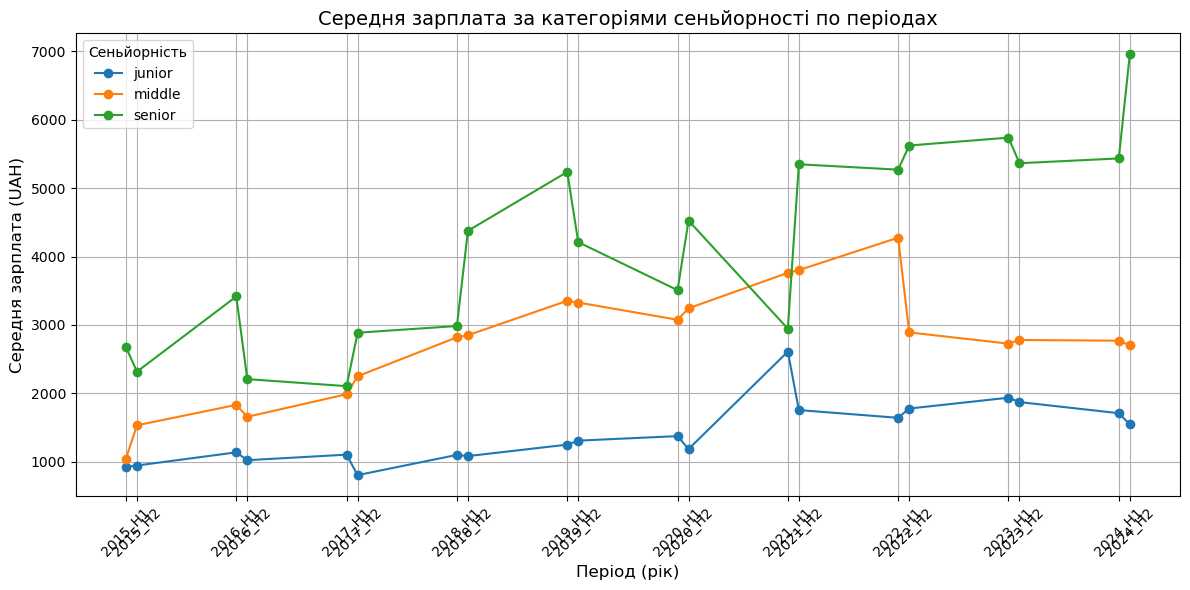

In [39]:
data = pd.read_csv("connnected_economic_data/connnected_economic_data_1.csv", low_memory=False)
# Перетворення періоду на числовий формат для коректного сортування
data['period_numeric'] = data['period'].str.replace('_H1', '.1').str.replace('_H2', '.2').astype(float)

# Побудова графіків
plt.figure(figsize=(12, 6))

# Фільтрування даних для кожної категорії сеньйорності
for seniority in ['junior', 'middle', 'senior']:
    subset = data[data['final_seniority'] == seniority]
    plt.plot(subset['period_numeric'], subset['average_salary'], marker='o', label=seniority)

# Налаштування графіка
plt.title('Середня зарплата за категоріями сеньйорності по періодах', fontsize=14)
plt.xlabel('Період (рік)', fontsize=12)
plt.ylabel('Середня зарплата (UAH)', fontsize=12)
plt.xticks(data['period_numeric'].unique(), data['period'].unique(), rotation=45)
plt.legend(title='Сеньйорність')
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()